<a href="https://colab.research.google.com/github/plaban1981/Agents/blob/main/Advanced_RAG_using_Docling_Extract_Thinker_Langchain_Groq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# requirements for this example:
%pip install -qU docling docling-core python-dotenv langchain-text-splitters langchain-huggingface langchain-chroma langchain-groq extract_thinker

In [ ]:
%pip install  ragas sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.

In [ ]:
%pip install -qU PyMuPDF PyPDF2 docling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 14.3 MB/s eta 0:00:00


## Download Data

In [ ]:
!mkdir Data

In [ ]:
!wget "https://arxiv.org/pdf/2312.10997" -O "Data/RAG.pdf"

--2024-12-28 14:21:11--  https://arxiv.org/pdf/2312.10997
Resolving arxiv.org (arxiv.org)... 151.101.3.42, 151.101.195.42, 151.101.131.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.3.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1662567 (1.6M) [application/pdf]
Saving to: ‘Data/RAG.pdf’

Data/RAG.pdf        100%[===================>]   1.58M  --.-KB/s    in 0.08s   

2024-12-28 14:21:11 (20.7 MB/s) - ‘Data/RAG.pdf’ saved [1662567/1662567]



## Import Required Libraries

In [ ]:
from langchain_groq import ChatGroq
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.retrievers.document_compressors import LLMChainFilter
from docling.document_converter import DocumentConverter
from extract_thinker import Extractor
from PyPDF2 import PdfReader
import fitz  # PyMuPDF for better PDF handling
import os

## Setup API Keys

In [ ]:
from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## Instantiate LLM

In [ ]:
from langchain_groq import ChatGroq
groq_llm = ChatGroq(
    temperature=0.1,
    model_name="llama2-70b-4096",
    groq_api_key=os.getenv("GROQ_API_KEY")
)

In [ ]:
groq_vision_llm = ChatGroq(
    temperature=0.1,
    model_name="llama-3.2-90b-vision-preview",
    groq_api_key=os.getenv("GROQ_API_KEY")
)

## Setup Extractor LLM

In [ ]:
from extract_thinker import Extractor, DocumentLoaderPyPdf, Contract
from typing import List
class PdfExtractor(Contract):
    title: str
    summary_of_page: str
    description: str
    image_description: str
    tabular_data_details : str
    figure_details : str
    table: bool
    figure: bool


#Initialize the extractor
extractor = Extractor()
extractor.load_document_loader(DocumentLoaderPyPdf())
extractor.load_llm("gpt-4o-mini") # or any other supported model

#Extract data from your document
result = extractor.extract("/content/Data/RAG.pdf", PdfExtractor)



In [ ]:
result.dict()

<ipython-input-98-b49c726f4d7a>:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result.dict()


{'title': 'Retrieval-Augmented Generation for Large Language Models: A Survey',
 'summary_of_page': 'This survey paper reviews the advancements in Retrieval-Augmented Generation (RAG) paradigms, focusing on their integration with Large Language Models (LLMs) to enhance knowledge retrieval and generation capabilities.',
 'description': 'The paper discusses the challenges faced by LLMs, such as hallucination and outdated knowledge, and presents RAG as a solution that combines intrinsic knowledge of LLMs with external databases. It categorizes RAG into three paradigms: Naive RAG, Advanced RAG, and Modular RAG, and examines their respective methodologies and technologies.',
 'image_description': '',
 'tabular_data_details': 'The paper includes a table summarizing various RAG methods, their retrieval sources, data types, and granularity, highlighting the diversity of approaches in the field.',
 'figure_details': 'Figures in the paper illustrate the technology tree of RAG research and the st

In [ ]:
from extract_thinker import Splitter, SplittingStrategy

result = Splitter().split(
    "/content/Data/RAG.pdf",
    strategy=SplittingStrategy.LAZY
)

TypeError: Can't instantiate abstract class Splitter with abstract methods belongs_to_same_document, split_eager_doc_group, split_lazy_doc_group

In [ ]:
from extract_thinker import TextSplitter, Process, SplittingStrategy
from extract_thinker.document_loader import DocumentLoaderTesseract

# Initialize process and loader
process = Process()
process.load_document_loader(DocumentLoaderTesseract("/usr/bin/tesseract"))

# Initialize text splitter with model
process.load_splitter(TextSplitter("llama-3.3-70b-versatile"))

# Split document
result = process.load_file("document.pdf")\
    .split(classifications, strategy=SplittingStrategy.EAGER)\
    .extract()

## Convert PDF to images

In [ ]:
%pip install pdf2jpg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 73.5 MB/s eta 0:00:00
  Created wheel for img2pdf: filename=img2pdf-0.5.1-py3-none-any.whl size=49276 sha256=ecd6869513208273c29a5d58a1122562b33a4f99995f450bb84bdbf604104dee
  Stored in directory: /root/.cache/pip/wheels/b7/e2/32/e12ea533072415219fc91a248cc413f34c505881ba850bf058
Successfully built img2pdf


In [ ]:
!mkdir Output

In [ ]:
from pdf2jpg import pdf2jpg
inputpath = "/content/Data/RAG.pdf"
outputpath = "/content/Output"


# to convert all pages
result = pdf2jpg.convert_pdf2jpg(inputpath, outputpath, dpi=300, pages="ALL")
print(result)

[{'cmd': ['java', '-jar', '/usr/local/lib/python3.10/dist-packages/pdf2jpg/pdf2jpg.jar', '-i', '/content/Data/RAG.pdf', '-o', '/content/Output', '-d', '300', '-p', 'ALL'], 'input_path': '/content/Data/RAG.pdf', 'output_pdfpath': '/content/Output/RAG.pdf_dir', 'output_jpgfiles': ['/content/Output/RAG.pdf_dir/0_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/1_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/10_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/11_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/12_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/13_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/14_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/15_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/16_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/17_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/18_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/19_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/2_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/20_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/3_RAG.pdf.jpg', '/content/Output/RAG.pdf_dir/4_RAG

In [ ]:
! sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (11.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [ ]:
%pip install --upgrade --quiet extract_thinker pytesseract Pillow

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from extract_thinker import LLM
grog_vision = LLM(model='groq/llama-3.2-90b-vision-preview')

#extractor.load_llm("gpt-4o-mini")

In [ ]:
from extract_thinker import Extractor, LLM, DocumentLoaderTesseract, Contract
# Initialize the extractor
extractor = Extractor()
extractor.load_llm(grog_vision)
extractor.load_document_loader(DocumentLoaderTesseract("/usr/bin/tesseract"))

In [ ]:
# Extract data
result = extractor.extract(r"/content/Output/RAG.pdf_dir/1_RAG.pdf.jpg", PdfExtractor)
print(result)

title='Retrieval-Augmented Generation (RAG) Research' summary_of_page='This paper reviews the current state of Retrieval-Augmented Generation (RAG) research, focusing on its core components, optimization methods, and evaluation metrics.' description='RAG is a paradigm that leverages external knowledge sources to enhance the performance of language models. This paper provides an overview of RAG, its evolution, and its applications.' image_description='Figure 1. Technology tree of RAG research. Figure 2. A typical application of RAG. Figure 3. The RAG research paradigm.' tabular_data_details='None' figure_details='Figure 1, Figure 2, Figure 3' table=False figure=True


In [ ]:
result.dict()

<ipython-input-96-b49c726f4d7a>:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result.dict()


{'title': 'Retrieval-Augmented Generation (RAG) Research',
 'summary_of_page': 'This paper reviews the current state of Retrieval-Augmented Generation (RAG) research, focusing on its core components, optimization methods, and evaluation metrics.',
 'description': 'RAG is a paradigm that leverages external knowledge sources to enhance the performance of language models. This paper provides an overview of RAG, its evolution, and its applications.',
 'image_description': 'Figure 1. Technology tree of RAG research. Figure 2. A typical application of RAG. Figure 3. The RAG research paradigm.',
 'tabular_data_details': 'None',
 'figure_details': 'Figure 1, Figure 2, Figure 3',
 'table': False,
 'figure': True}

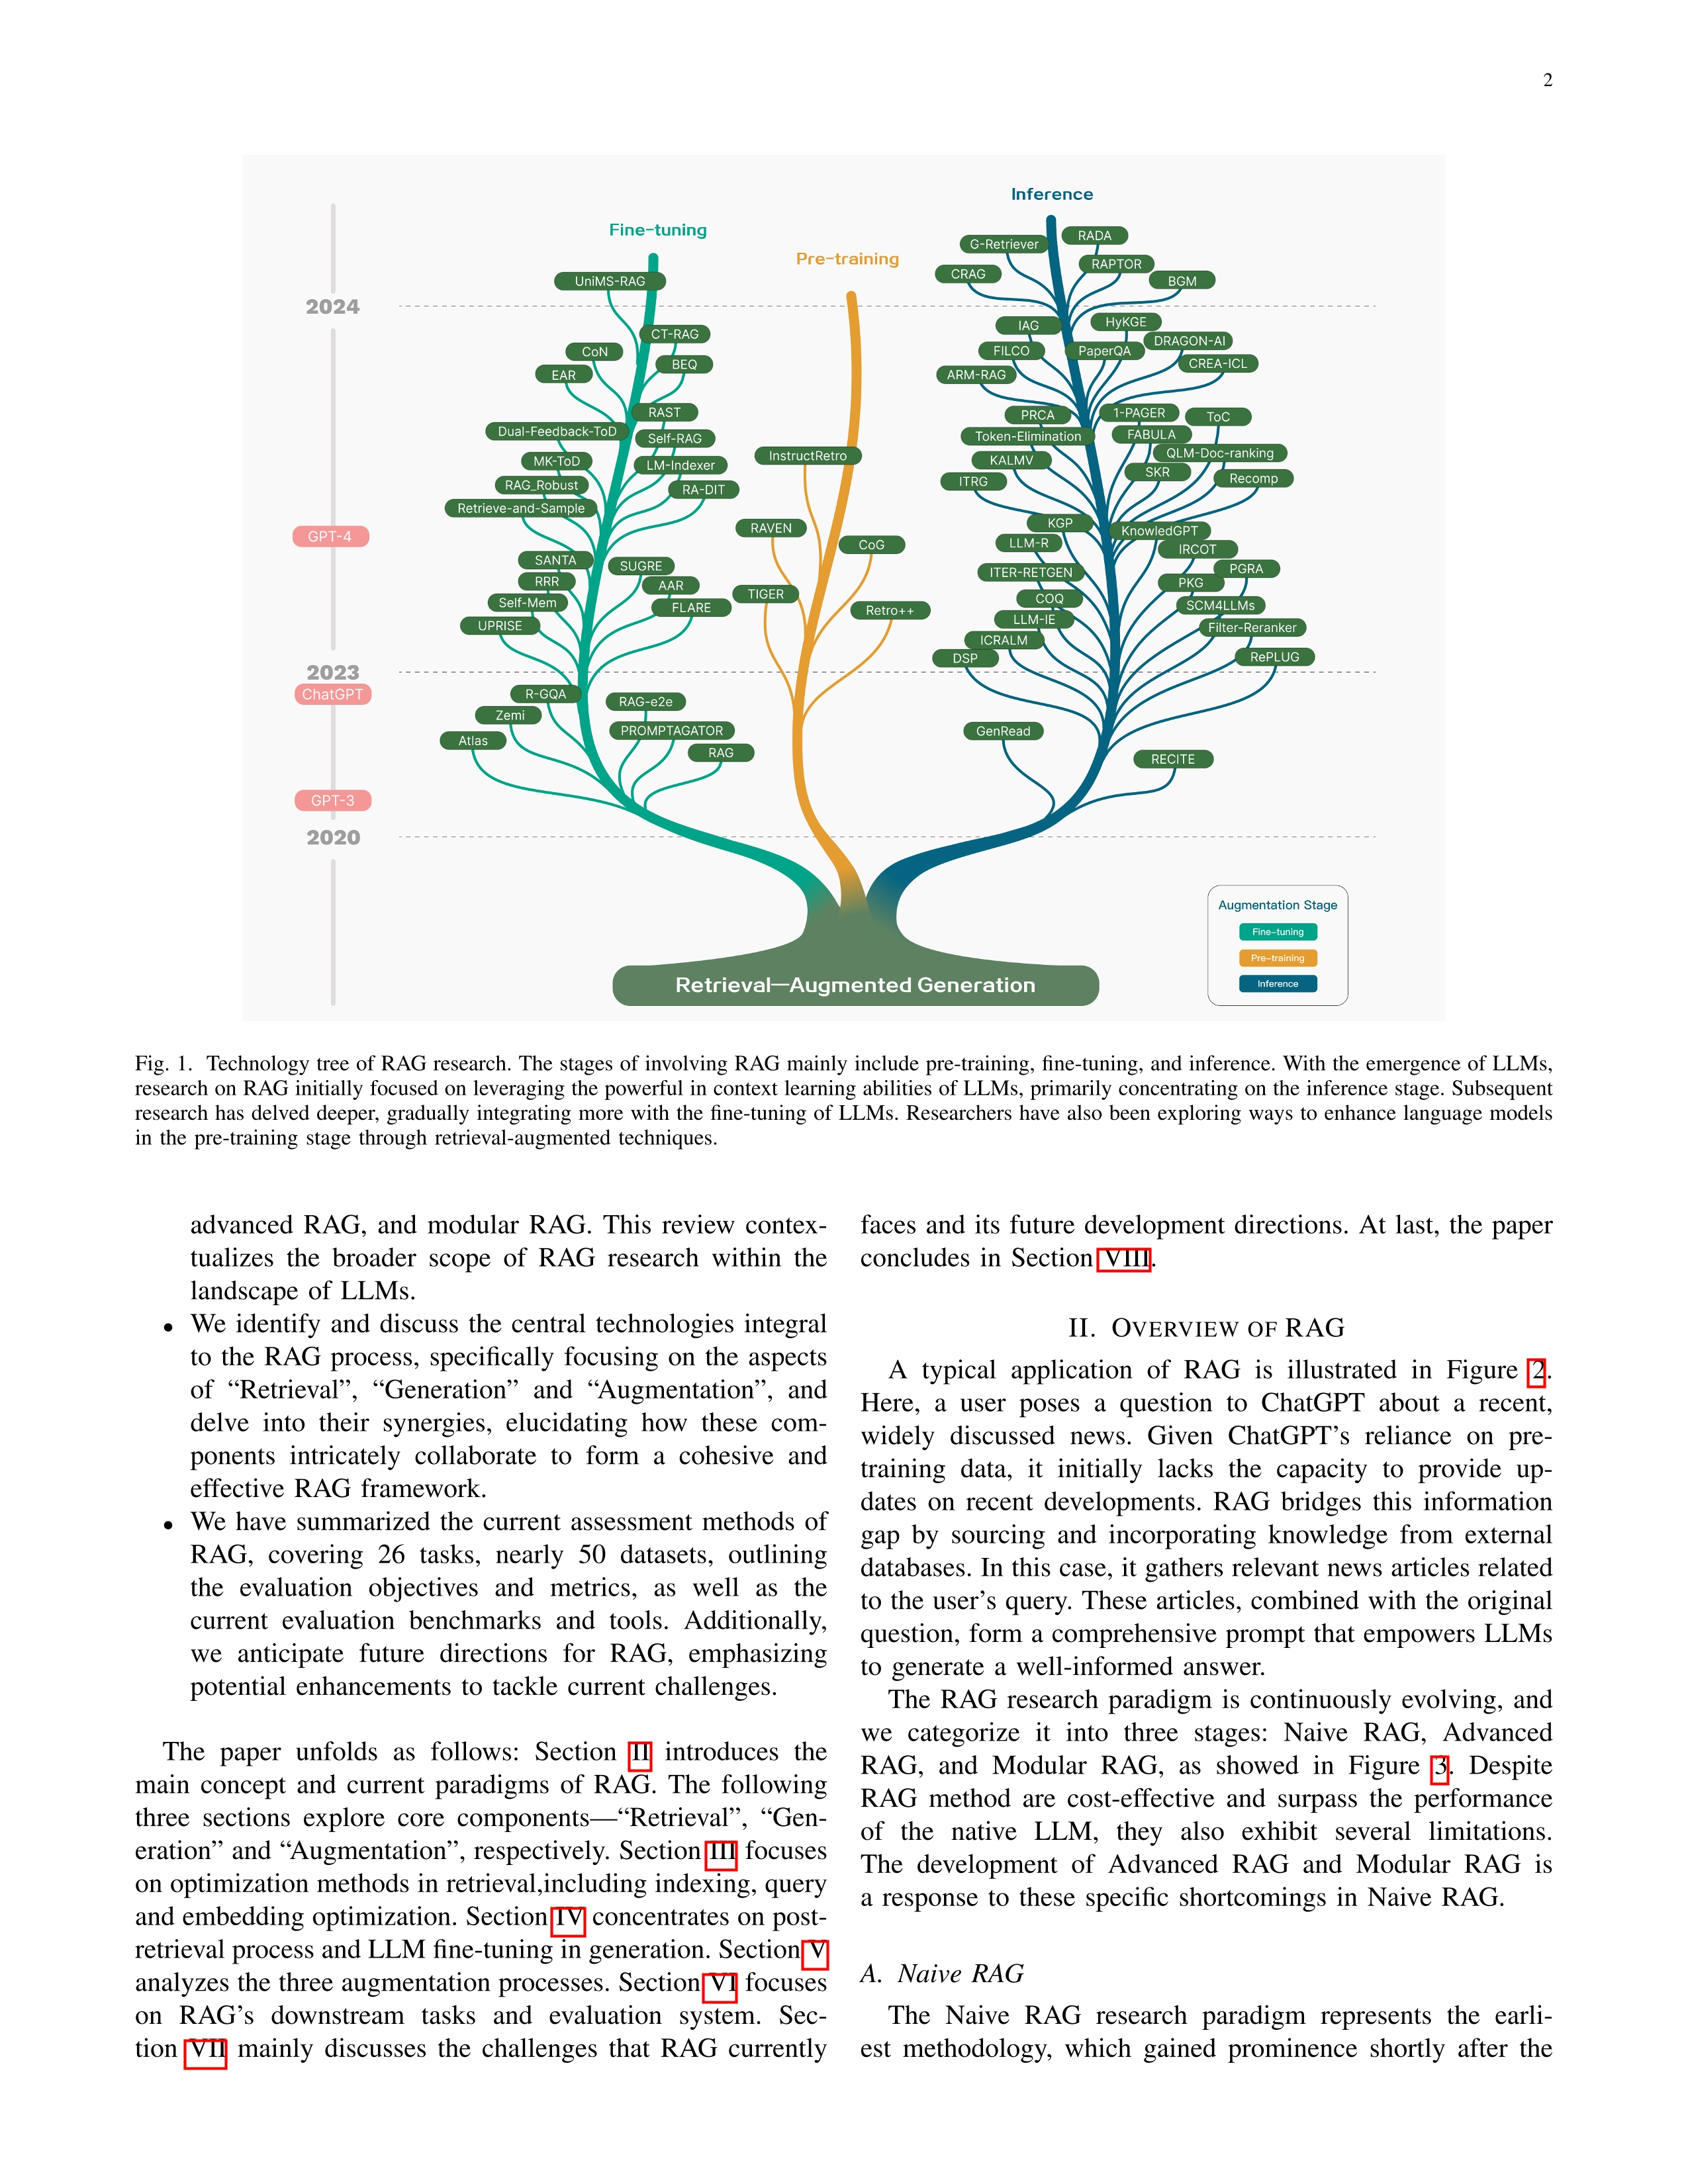

In [ ]:
from IPython.display import Image,display
display(Image("/content/Output/RAG.pdf_dir/1_RAG.pdf.jpg"))

## Generate Metadata for each page

In [ ]:
from tqdm import tqdm
image_dir = "/content/Output/RAG.pdf_dir"
metadata = {}
for img in tqdm(os.listdir(image_dir)):
  #
  result = extractor.extract(os.path.join(image_dir,img), PdfExtractor)
  final_dict = result.dict()
  page_number = img.split("_")[0]
  metadata[page_number] = final_dict


  0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-72-5324f4e95037>:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  final_dict = result.dict()
100%|██████████| 21/21 [06:28<00:00, 18.49s/it]


In [ ]:
len(metadata)

21

In [ ]:
metadata['0']

{'title': 'Retrieval-Augmented Generation for Large Language Models: A Survey',
 'summary_of_page': 'This paper provides a comprehensive review of Retrieval-Augmented Generation (RAG) methods, including their evolution, strengths, and weaknesses. It also discusses the integration of RAG within Large Language Models (LLMs) and its applications.',
 'description': 'Large Language Models (LLMs) have achieved remarkable success, but they still face significant limitations, especially in domain-specific or knowledge-intensive tasks. Retrieval-Augmented Generation (RAG) enhances LLMs by retrieving relevant document chunks from external knowledge bases through semantic similarity calculation.',
 'image_description': '',
 'tabular_data_details': ''}

In [ ]:
metadata['1']

{'title': 'Retrieval-Augmented Generation (RAG) Research',
 'summary_of_page': 'This paper reviews the current state of RAG research, focusing on its core components, optimization methods, and evaluation objectives.',
 'description': 'RAG is a research paradigm that aims to enhance language models by incorporating external knowledge from databases. It has three stages: Naive RAG, Advanced RAG, and Modular RAG.',
 'image_description': 'Figure 1: Technology tree of RAG research. Figure 2: A typical application of RAG. Figure 3: The three stages of RAG research.',
 'tabular_data_details': 'The paper summarizes the current assessment methods of RAG, covering 26 tasks, nearly 50 datasets, and outlining evaluation objectives and metrics.'}

In [ ]:
metadata['2']

{'title': "OpenAl's CEO Dismissal and Rehiring",
 'summary_of_page': "The article discusses the sudden dismissal and rehiring of OpenAl's CEO, Sam Altman, and its implications on the company's future direction and strategic decisions.",
 'description': "The article provides an analysis of the power struggles and corporate governance issues within OpenAl, and how the CEO's dismissal and rehiring reflect the company's internal dynamics.",
 'image_description': 'No images are available in the provided content.',
 'tabular_data_details': 'No tabular data is available in the provided content.'}

In [ ]:
from groq import Groq
import base64


# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "/content/Output/RAG.pdf_dir/1_RAG.pdf.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

client = Groq()

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Give a Detailed meaningful description of the figure. Please include facts like year,numbers and so on"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="llama-3.2-11b-vision-preview",
)

print(chat_completion.choices[0].message.content)

The image presents a comprehensive overview of the Research and Augmented Generation (RAG) framework, showcasing its evolution from 2000 to 2022. The figure is divided into two main sections: the left side displays a tree diagram illustrating the development of RAG over time, while the right side provides a detailed explanation of the framework.

**Tree Diagram:**

*   The tree diagram is organized into four branches, each representing a distinct stage in the development of RAG.
*   The first branch (2000-2005) represents the initial stage of RAG, characterized by sparse research and limited advancements.
*   The second branch (2006-2010) marks a significant increase in research activity, leading to the development of advanced RAG architectures.
*   The third branch (2011-2015) witnesses further enhancements in RAG, including the integration of new features and techniques.
*   The fourth branch (2016-2022) represents the most recent stage of RAG, featuring state-of-the-art models and e

## Instantiate Embedding

In [ ]:


class AdvancedRAGPipeline:
    def __init__(self):
        self.embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-mpnet-base-v2"
        )
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200
        )
        self.doc_processor = DocumentProcessor()
        self.extract_thinker = ExtractThinker()

    def process_document(self, file_path):
        # Load and process document using Docling
        doc = Document(file_path)
        processed_doc = self.doc_processor.process(doc)

        # Extract structured information using ExtractThinker
        extracted_info = self.extract_thinker.process(
            processed_doc.text,
            extraction_type="full"
        )

        # Split text into chunks
        chunks = self.text_splitter.split_text(processed_doc.text)

        # Create vector store
        vectorstore = DocArrayInMemorySearch.from_texts(
            chunks,
            self.embeddings
        )

        return vectorstore, extracted_info

    def create_llm_chain_filter(self):
        # Create LLMChainFilter for noise reduction
        prompt_template = """Given the following context and question, determine if the context is relevant.
        Context: {context}
        Question: {question}

        Return 'true' if the context is relevant, 'false' if not.
        Answer:

https://huggingface.co/PatronusAI/glider